# TFC - DEISI258 - Modelamento multi-agente de interações em grupos sociais

Aluno: **Paulo Pinto** a21906966

Orientador: **Manuel Marques Pita**


Neste notebook:
- É feita a conexão ao NetLogo através da biblioteca pyNetLogo
- É carregado o modelo desenvolvido para o âmbito do TFC
- A simulação é executada 50 vezes, para obter significância estatística
- Os dados são visualizados e analisados

## Imports

### Setup Virtual Environment

Create virtual environment 'venv' -> `python3 -m venv venv` or `python3.[version_number] -m venv venv`

Activate 'venv' -> Linux `source venv/bin/activate` | Windows `. venv\scripts\activate`

Install required packages -> `pip install -r requirements.txt`

Errors - 
- `No module named 'pip'` -> python -m ensurepip
- `No module named jpype` -> pip install jpype1

In [1]:
import os
from sys import platform

import pyNetLogo

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

In [2]:
# add ( NetLogo : path )  as an environment variable
if platform == "linux":
    os.environ["NetLogo"] = "/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1"
    
for key in os.environ:
    if key.lower() == "netlogo":
        print(f"{key} -> {os.environ[key]}")

# connect to netlogo
netlogo = pyNetLogo.NetLogoLink(
    gui=False,
    netlogo_home = os.environ['NetLogo'],
    netlogo_version="6.2",
)

NetLogo -> /home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1


In [3]:
# load model
if platform == "linux":
    ku_model_path = os.path.abspath(os.getcwd()) + "/files/knowledge_units_with_board.nlogo"    
elif platform == "win32":
    ku_model_path = os.path.abspath(os.getcwd()) + "\\files\\knowledge_units_with_board.nlogo"

def load_model(path):
    netlogo.load_model(path)
    netlogo.command("set number_of_agents 15")
    netlogo.command("setup")
    netlogo.command("repeat 200 [go]")
    
load_model(ku_model_path)

In [4]:
# change interface vars
# keys = [
#     "number_of_agents",
#     "ku_number",
#     "ku_len",
#     "c_threshold",
# ]
# values = [6, 9, 8, 0.5]

# experiment = {k: v for k, v in zip(keys, values)}to-report get-all-compatibilities

# Set the input parameters
# for key, value in zip(keys, values):
#     if key == "random-seed":
#         # The NetLogo random seed requires a different syntax
#         netlogo.command("random-seed {}".format(value))
#     else:
#         # Otherwise, assume the input parameters are global variables
#         netlogo.command(f"set {key} {value}")
# netlogo.command("set random-seed 250474")

In [5]:
def nd_array_to_compats(ndarr):
    compats = []
    curr_compat = []

    # iterate current and next element
    for curr, _next in zip(ndarr, ndarr[1:]):
        curr_compat.append(curr)

        # if next element is lower than current, a new instance started
        if _next < curr:
            # add compats and reset temp var
            compats.append(curr_compat)
            curr_compat = []

    # REMOVE FIRST ELEMENT
    compats[0].pop(0)

    return compats

# colours = ['red', 'green', 'blue']
def gen_graph(compatibilities):
    fig, ax = plt.subplots()
    ax.set_xlabel("Tick")
    ax.set_ylabel("Hamming Distances")
    ax.set_aspect(100)
    plt.title("Hamming Distances per Tick")
    # fig.set_size_inches(5, 5)

    plt.yticks([0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0])

    for index, compats in enumerate(compatibilities):
        if index % 10 == 0:
            for c, size in Counter(compats).items():
                # print(size)
                ax.scatter(x=index, y=c, s=(size**2), color="blue")  # color=colours[size%3]

    # sns.scatterplot(data= compatibilities)

    plt.savefig("files/new_plot.jpg", dpi=300, transparent=False)
    plt.show()


def plot_1d_arr(arr, ylabel, type="line",aspect=70):
    df = pd.DataFrame(arr)

    fig, ax = plt.subplots()
    ax.set_aspect(aspect)
    ax.set_xlabel("Tick")
    ax.set_ylabel(ylabel)
    fig.patch.set_facecolor('white')
    plt.title(f"{ylabel} / Tick")

    if type == "line":
        sns.lineplot(data=df, x=range(len(arr)), y=df[0])
    elif type == "scatter":
        sns.scatterplot(data=df, x=range(len(arr)), y=df[0])
    else:
        sns.barplot(data=df, x=range(len(arr)), y=df[0])
    
    # print(df.describe())

           0
count  201.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0


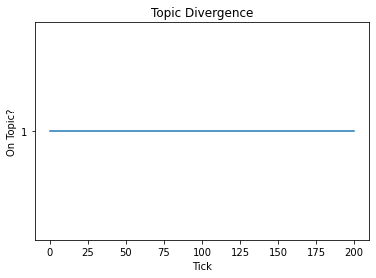

In [6]:
netlogo.command("setup")
netlogo.command("set female_prob_exploit 0.5")
netlogo.command("set male_prob_exploit 0.3")
netlogo.command("repeat 200 [go]")

all_compat_ratios = netlogo.report("compat-ratio-report")

compat_df = pd.DataFrame(all_compat_ratios)
# compat_df

fig, ax = plt.subplots()
ax.set_xlabel("Tick")
ax.set_ylabel("On Topic?")
plt.title("Topic Divergence")

plt.yticks([-1.0, 0.0, 1.0])

sns.lineplot(data=compat_df, x=range(201), y=compat_df[0])

print(compat_df.describe())

In [7]:
def show_sim_stats():
    """prints graph pertaining to the ran simulation"""
    plot_1d_arr(netlogo.report("burst-length-report"), ylabel="Burst Length", type="line", aspect=20)
    # save_to_file("burst_lengths", netlogo.report("burst-length-report"))
    participation = netlogo.report("mf-participation-report")
    female_part = participation[1::2] # Elements from list1 starting from 1 iterating by 2
    male_part = participation[::2]

    plot_1d_arr(female_part, ylabel="F Participation", type="line")
    plot_1d_arr(male_part, ylabel="M Participation", type="line")


# def save_to_file(file_name, content):
#     with open(f"outputs/{file_name}.csv", "w+") as fp:
#         fp.write(content.tostring())

def read_from_file(file_name):
    with open(f"{file_name}") as fp:
        return np.fromstring(fp.readlines(),  dtype=int)

def show_topic_divergence(scenario):
    topic = [[],[]]

    messages = netlogo.report("get-in-topic").astype(int)
    # should_be = [[2, 1, 3], [3, 1, 1, 4]]

    with open(f"plots/{scenario}_in-topic-data.csv", "a+") as fp:
        fp.write(f"{list(messages)}")
        fp.write("\n")
    
    prev_compat = False

    for curr_compat in messages:
        
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat])-1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat

    # print(topic)

    sns.displot(topic[0], kde=True).set(title="Lengths of Out-of-Topic Discussions")
    x_ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    plt.xticks(x_ticks)

    sns.displot(topic[1], kde=True).set(title="Lengths of In-Topic Discussions")

In [8]:
scenarios = {
    # Scenario:sub-scenario : [Attentio Norm, females, males, female_prob_exploit, male_prob_exploit]
    # Working class
    1.1 : ["General", 1, 1, 0.45, 0.25],
    1.2 : ["General", 2, 1, 0.45, 0.25],
    1.3 : ["General", 1, 2, 0.45, 0.25],
    1.4 : ["Gendered", 2, 1, 0.45, 0.25],
    1.5 : ["Gendered", 1, 2, 0.45, 0.25],
    
    # Upper class    
    2.1 : ["General", 1, 1, 0.85, 0.8],
    2.2 : ["General", 2, 1, 0.85, 0.8],
    2.3 : ["General", 1, 2, 0.85, 0.8],
    2.4 : ["Gendered", 2, 1, 0.85, 0.8],
    2.5 : ["Gendered", 1, 2, 0.85, 0.8],

    # Middle class    
    3.1 : ["General", 1, 1, 0.6, 0.5],
    3.2 : ["General", 2, 1, 0.6, 0.5],
    3.3 : ["General", 1, 2, 0.6, 0.5],
    3.4 : ["Gendered", 2, 1, 0.6, 0.5],
    3.5 : ["Gendered", 1, 2, 0.6, 0.5],
    
}

# old scenarios
# scenarios = {
#     # Scenario:sub-scenario : [Attentio Norm, females, males, female_prob_exploit, male_prob_exploit]
#     # Working class
#     1.1 : ["General", 1, 1, 0.65, 0.25],
#     1.2 : ["General", 2, 1, 0.65, 0.25],
#     1.3 : ["Gendered", 2, 1, 0.65, 0.25],
    
#     # Middle class
#     2.1 : ["General", 1, 1, 0.7, 0.5],
#     2.2 : ["General", 2, 1, 0.7, 0.5],
#     2.3 : ["Gendered", 2, 1, 0.7, 0.5],
    
#     # Upper class
#     3.1 : ["General", 1, 1, 0.85, 0.75],
#     3.2 : ["General", 2, 1, 0.85, 0.75],
#     3.3 : ["Gendered", 2, 1, 0.85, 0.75],
# }


# run_scenario(*scenarios[1.1], 1.1, 50)

In [12]:

def plot_topic(indexes, data, in_out, scenario):

    if in_out not in ["in", "out", "polarised"]: 
        print("invalid in / out")
        return
    
    topic_print = 'In-Topic' if in_out == 'in' else 'Out-of-Topic' if in_out == 'out' else 'Polarised'
    
    plt.ylabel("Count")

    plt.xlabel(f"{topic_print} Length")

    plt.title(f"{scenario} Lengths of {topic_print} Discussions")
    plt.bar(indexes, list(data.values()))
    plt.xticks(indexes, list(data.keys()))

    plt.savefig(f"plots/{scenario}_{in_out}_topic.png")
    plt.show()

In [9]:
# gets messages, returns in/out of topic lengths
# [1, 0, 0, 0, 1, 1] -> [[3], [1, 2]]
def split_topics(messages):
    topic = [[],[]]
    print(messages)
    # convert to int
    messages = [int(e) for e in messages]
    print(messages)
    prev_compat = 1 - messages[0]

    for curr_compat in messages:
        if curr_compat == -1 or curr_compat == "-1": curr_compat = 0
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat]) - 1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat
    
    print(topic)
    return topic

## Read compats with polarisation

In [31]:
# compat-ratio-report-with-polarisation
def split_topics_polarised(messages):
    topic = [[],[],[]]
    # convert to int
    messages = [int(e) for e in messages]
    
    prev_compat = -1

    topic_indexes = {
        -1 : 0,
        0 : 1,
        1 : 2,
    }

    for curr_compat in messages:
        index = topic_indexes[curr_compat]
        
        if prev_compat == curr_compat: # continue last count    
            topic[index][len(topic[index]) - 1] += 1
        else: # create new count
            topic[index].append(1)
        
        prev_compat = curr_compat
    
    # print(topic)
    return topic

# concat all in/out of topic lengths
def read_in_topic_polarised(scenario):
    file_path = f"outputs/{scenario}_compat_ratios_polarisation.csv"

    in_topic = []
    out_topic = []
    polarised_topic = []

    with open(file_path) as fp:
        
        for l in fp.readlines():
            # -1 -> 0 | 1 -> 1
            # print(l.split())
            # lst = [e for e in l if e.isalnum() or e == "-1"]
            lst = [e for e in l.strip("\n").split(",")]
            # print(f"{lst=}")
            topics = split_topics_polarised(lst)
            out_topic += topics[0]
            polarised_topic += topics[1]
            in_topic += topics[2]

    return out_topic, polarised_topic, in_topic

def run_scenario_polarised(method, females, males, f_exploit, m_exploit, scenario, iterations = 10):
    file_path = f"outputs/{scenario}_compat_ratios_polarisation.csv"
    if os.path.exists(file_path): os.remove(file_path) # reset file

    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')

    for _ in range(iterations):    
        netlogo.command("setup")
        netlogo.command("repeat 200 [go]")

        messages = netlogo.report("compat-ratio-report-with-polarisation").astype(int)
                
        with open(file_path, "a+") as fp:
            fp.write(','.join(str(x) for x in messages))
            fp.write("\n")
    
    print(f"{scenario=} done")

scenario_ids = [1.2, 2.2, 2.3]
for s in scenario_ids:
    run_scenario_polarised(*scenarios[s], s)

scenario=1.2 done
scenario=2.2 done
scenario=2.3 done


In [29]:
def plot_from_files_polarised(scenario):
    # return the length counts for in/out topic
    out_topic, polarised_topic, in_topic = read_in_topic_polarised(scenario)
        
    out_topic_counter = dict(sorted(Counter(out_topic).items()))
    indexes = np.arange(len(out_topic_counter))
    plot_topic(indexes, out_topic_counter, "out",  scenario)
    
    in_topic_counter = dict(sorted(Counter(in_topic).items()))
    indexes = np.arange(len(in_topic_counter))
    plot_topic(indexes, in_topic_counter, "in",  scenario)

    polarised_topic_counter = dict(sorted(Counter(polarised_topic).items()))    
    indexes = np.arange(len(polarised_topic_counter))
    plot_topic(indexes, polarised_topic_counter, "polarised",  scenario)

    common_params = dict(bins=100, range=(1, 200), density = True)

    ax = plt.hist((out_topic, in_topic, polarised_topic), **common_params)
    plt.legend(["out of topic", "in topic", "polarised discussion"])
    plt.title("Type of Discussion Length")
    plt.ylabel("Prevalence")
    plt.xlabel("Length of Discussion")

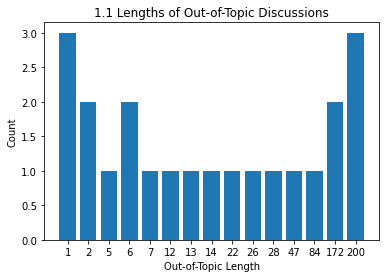

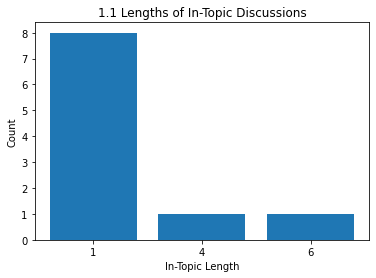

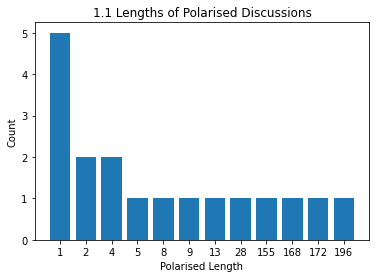

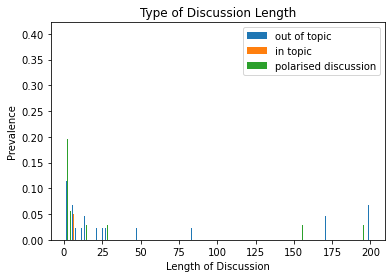

In [30]:
scenario = 1.1
plot_from_files_polarised(1.1)

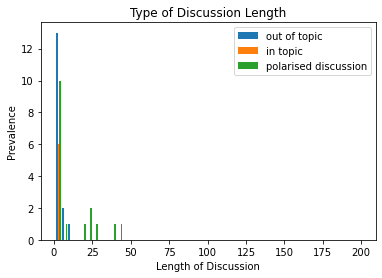

In [ ]:
common_params = dict(bins=50, range=(1, 200))

ax = plt.hist((out_topic, in_topic, polarised_topic), **common_params)
plt.legend(["out of topic", "in topic", "polarised discussion"])
plt.title("Type of Discussion Length")
plt.ylabel("Prevalence")
plt.xlabel("Length of Discussion")

# ax.legend()
plt.show()

In [ ]:
read_in_topic(1.1, True)

lst=['1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1\n']
['1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1\n']
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[[50], [1]]


([50], [1])

In [ ]:
messages = netlogo.report("compat-ratio-report").astype(int)
file_path = f"outputs/1.1_compat_ratios.csv"
    
with open(file_path, "a+") as fp:
    fp.write(','.join(str(x) for x in messages))
    fp.write("\n")

In [11]:
# concat all in/out of topic lengths
def read_in_topic(scenario, divergency):

    if divergency:
        file_path = f"outputs/{scenario}_compat_ratios.csv"
    else:
        file_path = f"outputs/{scenario}_topic_data.csv"

    in_topic = []
    out_topic = []

    with open(file_path) as fp:
        
        for l in fp.readlines():
            # -1 -> 0 | 1 -> 1
            # print(l.split())
            # lst = [e for e in l if e.isalnum() or e == "-1"]
            lst = [e for e in l.split(",")]
            print(f"{lst=}")
            topics = split_topics(lst)
            out_topic += topics[0]
            in_topic += topics[1]

    return out_topic, in_topic

def run_scenario(method, females, males, f_exploit, m_exploit, scenario, iterations = 5):
    file_path = f"outputs/{scenario}_compat_ratios.csv"
    if os.path.exists(file_path): os.remove(file_path) # reset file

    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')

    for _ in range(iterations):    
        netlogo.command("setup")
        netlogo.command("repeat 50 [go]")

        messages = netlogo.report("compat-ratio-report").astype(int)
        with open(file_path, "a+") as fp:
            # fp.write(f"{[x for x in messages]}")
            fp.write(','.join(str(x) for x in messages))
            fp.write("\n")

    # return the length counts for in/out topic
    out_topic, in_topic = read_in_topic(scenario, divergency = True)

    out_topic = list(map(int,out_topic)) # map here is irrelevant?
    in_topic = list(map(int,in_topic))
    return  dict(sorted(Counter(out_topic).items())), dict(sorted(Counter(in_topic).items())), 
    # return Counter(out_topic), Counter(in_topic)

    # show_topic_divergence(scenario)
    # show_sim_stats()


In [ ]:
# in_topic_counter = list(map(int,in_topic_counter))

# print(in_topic_counter)

# sorted_keys = sorted(in_topic_counter.keys())
# new_dict = {}
# for k in sorted_keys:
#     new_dict[k] = in_topic_counter[k]

# in_topic_counter = new_items

# print(out_topic_counter)
# sorted_dict = dict(sorted(out_topic_counter.items()))
# print(sorted_dict)
# ind = np.arange(len(in_topic_counter))
# data = in_topic_counter

# plt.xlabel("Out-of-Topic Length")
# plt.ylabel("Count")
# plt.title("Lengths of Out-of-Topic Discussions")
# plt.bar(ind, list(data[0]))
# plt.xticks(ind, list(data[1]))
# plt.show()
# out_topic_counter = sorted(out_topic_counter.items())

In [ ]:
# data = {1: 9426, 2: 4367, 3: 2157, 4: 1079, 5: 517, 6: 234, 7: 123, 8: 61, 9: 36, 10: 8, 11: 5, 12: 4, 16: 2, 13: 2, 18: 1, 14: 1}
# scenario = 1.1
# out_topic_counter, in_topic_counter = run_scenario(*scenarios[scenario], scenario, 50)

# # sort
# out_topic_counter = dict(sorted(out_topic_counter.items()))
# in_topic_counter = dict(sorted(in_topic_counter.items()))

# ind = np.arange(len(out_topic_counter))
# data = out_topic_counter

# plt.xlabel("Out-of-Topic Length")
# plt.ylabel("Count")
# plt.title("Lengths of Out-of-Topic Discussions")
# plt.bar(ind, list(data.values()))
# plt.xticks(ind, list(data.keys()))
# plt.show()
# # plt.savefig(f"{scenario}_out_topic_linear.png")

# plt.xlabel("Out-of-Topic Length")
# plt.ylabel("Count")
# plt.title("Lengths of Out-of-Topic Discussions - Log")
# plt.bar(ind, list(data.values()))
# plt.xticks(ind, list(data.keys()))
# plt.yscale("log")
# plt.show()
# # plt.savefig(f"{scenario}_out_topic_log.png")

# ind = np.arange(len(in_topic_counter))
# data = in_topic_counter

# plt.xlabel("In-Topic Length")
# plt.ylabel("Count")
# plt.title("Lengths of In-Topic Discussions")
# plt.bar(ind, list(data.values()))
# plt.xticks(ind, list(data.keys()))
# plt.show()
# # plt.savefig(f"{scenario}_in_topic_linear.png")

# plt.xlabel("In-Topic Length")
# plt.ylabel("Count")
# plt.title("Lengths of In-Topic Discussions - Log")
# plt.bar(ind, list(data.values()))
# plt.xticks(ind, list(data.keys()))
# plt.yscale("log")
# plt.show()
# plt.savefig(f"{scenario}_in_topic_log.png")

# haven't tested savefig

In [ ]:
reduced_scenarios = {
    # Working class
    1.1 : ["General", 1, 1, 0.45, 0.25],
    # 1.5 : ["Gendered", 1, 2, 0.45, 0.25],
    
    # Upper class    
    # 2.1 : ["General", 1, 1, 0.85, 0.8],
    # 2.5 : ["Gendered", 1, 2, 0.85, 0.8],
}

# run 3 scenarios
for scenario_id,v in reduced_scenarios.items():
    out_topic_counter, in_topic_counter = run_scenario(*v, scenario_id, 1)

    # sort
    out_topic_counter = dict(sorted(out_topic_counter.items()))
    in_topic_counter = dict(sorted(in_topic_counter.items()))

    indexes = np.arange(len(out_topic_counter))

    plot_topic(indexes, out_topic_counter, "out",  scenario_id)

    indexes = np.arange(len(in_topic_counter))

    plot_topic(indexes, in_topic_counter, "in",  scenario_id)

# TODO - NORMALIZED HISTOGRAM

lst=['[1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1]\n']
['[1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1]\n']


ValueError: invalid literal for int() with base 10: '[1'

TODO : 

In [ ]:
out_topic_counter

read only

In [ ]:

out_topic, in_topic = read_in_topic(2.3)

out_topic = list(map(int,out_topic))
in_topic = list(map(int,in_topic))

out_topic_counter = dict(sorted(Counter(out_topic).items()))
in_topic_counter = dict(sorted(Counter(in_topic).items()))

ind = np.arange(len(out_topic_counter))
data = out_topic_counter

scenario_id = 2.3

indexes = np.arange(len(out_topic_counter))

plot_topic(indexes, out_topic_counter, "out",  scenario_id)
plot_topic(indexes, out_topic_counter, "out",  scenario_id)

indexes = np.arange(len(in_topic_counter))

plot_topic(indexes, in_topic_counter, "in",  scenario_id)
plot_topic(indexes, in_topic_counter, "in",  scenario_id)
